In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

from torchvision import transforms

import torchvision.transforms as transforms
cudnn.benchmark = True
plt.ion()   # interactive mode

from sklearn import svm, preprocessing, model_selection, metrics, base

import os
from sklearn.model_selection import train_test_split

from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve


import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

from torch.utils.data import DataLoader, random_split

cudnn.benchmark = True

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader

import torch.nn.functional as F
import torch.optim as optim
from torch import nn

import torchvision.transforms as T
from torchvision.datasets import ImageFolder

In [ ]:
# pip install albumentations --user


In [ ]:
import zipfile
from tqdm import tqdm
fname = './AEP_hourly.csv.zip'
path=・…/
with zipfile.ZipFile(fname, 'r') as 2f:
for entry in tqdm(zf. infolist(), desc='Extracting '):
try:
zf.extract(entry, path)
except zipfile.error as e:
pass

tar -xf имя.tar.gz

In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
wd = !pwd
path = wd[0] + '/'
path

'/home/jupyter/work/resources/'

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm


sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [6]:
def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss, train_accuracy = 0.0, 0.0
    model.train()
    for images, labels in tqdm(train_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.long().to(device)  # labels: batch_size

        optimizer.zero_grad()
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.shape[0]
        train_accuracy += (logits.argmax(dim=1) == labels).sum().item()
    
    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    return train_loss, train_accuracy


@torch.no_grad()
def validation_epoch(model, criterion, test_loader, tqdm_desc):
    test_loss, test_accuracy = 0.0, 0.0
    model.eval()
    for images, labels in tqdm(test_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.long().to(device)  # labels: batch_size
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)

        test_loss += loss.item() * images.shape[0]
        test_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    return test_loss, test_accuracy

    
def train(model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs):
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        test_loss, test_accuracy = validation_epoch(
            model, criterion, test_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

    return train_losses, test_losses, train_accuracies, test_accuracies

In [23]:
data_dir = "/home/jupyter/datasphere/project/study-competition-2-dl-2024-1/data_cry/train1"
images = []
labels = []

# Обходим все подпапки в папке с данными
for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    if os.path.isdir(label_dir):
        for image_name in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_name)
            images.append(image_path)
            labels.append(label)

# Разделяем данные на тренировочный и валидационный наборы
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Выводим информацию о разделении данных
print("Количество изображений в тренировочном наборе:", len(X_train))
print("Количество изображений в валидационном наборе:", len(X_val))

Количество изображений в тренировочном наборе: 12038
Количество изображений в валидационном наборе: 3010


In [24]:
class Odin(Dataset):
    SPLIT_RANDOM_SEED = 42
    TEST_SIZE = 0.25

    def __init__(self, root, train=True, load_to_ram=True, transform=None):
        super().__init__()
        self.root = root
        self.train = train
        self.load_to_ram = load_to_ram # подгружать ли датасет в память полностью
        self.transform = transform
        self.to_tensor = T.ToTensor()
        self.all_files = []
        self.all_labels = []
        self.images = []

        self.classes = sorted(os.listdir(self.root))
        for i, class_name in tqdm(enumerate(self.classes), total=len(self.classes)):
            files = sorted(os.listdir(os.path.join(self.root, class_name)))
            train_files, test_files = train_test_split(files, random_state=self.SPLIT_RANDOM_SEED + i,
                                                       test_size=self.TEST_SIZE)
            if self.train:
                self.all_files += train_files
                self.all_labels += [i] * len(train_files)
                if self.load_to_ram:
                    self.images += self._load_images(train_files, i)

            else:
                self.all_files += test_files
                self.all_labels += [i] * len(test_files)
                if self.load_to_ram:
                    self.images += self._load_images(test_files, i)

    def _load_images(self, image_files, label):
        images = []
        for filename in image_files:
            image = Image.open(os.path.join(self.root, self.classes[label], filename)).convert('RGB')
            images += [image]

        return images

    def __len__(self):
        return len(self.all_files)

    def __getitem__(self, item):
        label = self.all_labels[item]
        if self.load_to_ram:
            image = self.images[item]
        else:
            filename = self.all_files[item]
            image = Image.open(os.path.join(self.root, self.classes[label], filename)).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [ ]:
# data_dir = 'data_cry/train1'
# root_directory = os.path.join(data_dir, "data_cry/train1")

# bean_directory = os.path.join(root_directory, "Bean_0")
# bitter_gourd_directory = os.path.join(root_directory, "Bitter_Gourd_1")
# bottle_gourd_directory = os.path.join(root_directory, "Bottle_Gourd_2")
# brinjal_directory = os.path.join(root_directory, "Brinjal_3")
# broccoli_directory = os.path.join(root_directory, "Broccoli_4")
# cabbage_directory = os.path.join(root_directory, "Cabbage_5")
# capsicum_directory = os.path.join(root_directory, "Capsicum_6")
# carrot_directory = os.path.join(root_directory, "Carrot_7")
# cauliflower_directory = os.path.join(root_directory, "Cauliflower_8")
# cucumber_directory = os.path.join(root_directory, "Cucumber_9")
# papaya_directory = os.path.join(root_directory, "Papaya_10")
# potato_directory = os.path.join(root_directory, "Potato_11")
# pumpkin_directory = os.path.join(root_directory, "Pumpkin_12")
# radish_directory = os.path.join(root_directory, "Radish_13")
# tomato_directory = os.path.join(root_directory, "Tomato_14")

# bean_images_filepaths = sorted([os.path.join(bean_directory, f) for f in os.listdir(bean_directory)])
# BiGourd_images_filepaths = sorted([os.path.join(bitter_gourd_directory, f) for f in os.listdir(bitter_gourd_directory)])
# BoGourd_images_filepaths = sorted([os.path.join(bottle_gourd_directory, f) for f in os.listdir(bottle_gourd_directory)])
# brinjal_images_filepaths = sorted([os.path.join(brinjal_directory, f) for f in os.listdir(brinjal_directory)])
# broccoli_images_filepaths = sorted([os.path.join(broccoli_directory, f) for f in os.listdir(broccoli_directory)])
# cabbage_images_filepaths = sorted([os.path.join(cabbage_directory, f) for f in os.listdir(cabbage_directory)])
# capsicum_images_filepaths = sorted([os.path.join(capsicum_directory, f) for f in os.listdir(capsicum_directory)])
# carrot_images_filepaths = sorted([os.path.join(carrot_directory, f) for f in os.listdir(carrot_directory)])
# cauliflower_images_filepaths = sorted([os.path.join(cauliflower_directory, f) for f in os.listdir(cauliflower_directory)])
# cucumber_images_filepaths = sorted([os.path.join(cucumber_directory, f) for f in os.listdir(cucumber_directory)])
# papaya_images_filepaths = sorted([os.path.join(papaya_directory, f) for f in os.listdir(papaya_directory)])
# potato_images_filepaths = sorted([os.path.join(potato_directory, f) for f in os.listdir(potato_directory)])
# pumpkin_images_filepaths = sorted([os.path.join(pumpkin_directory, f) for f in os.listdir(pumpkin_directory)])
# radish_filepaths = sorted([os.path.join(radish_directory, f) for f in os.listdir(radish_directory)])
# tomato_images_filepaths = sorted([os.path.join(tomato_directory, f) for f in os.listdir(tomato_directory)])


# images_filepaths = [*bean_images_filepaths, *BiGourd_images_filepaths, *BoGourd_images_filepaths,*brinjal_images_filepaths,
#                    *broccoli_images_filepaths,*cabbage_images_filepaths,*capsicum_images_filepaths,*carrot_images_filepaths,
#                    *cauliflower_images_filepaths,*cucumber_images_filepaths,*papaya_images_filepaths,*potato_images_filepaths,
#                    *pumpkin_images_filepaths, *radish_filepaths,*tomato_images_filepaths]
# correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

# random.seed(42)
# random.shuffle(correct_images_filepaths)
# train_images_filepaths = correct_images_filepaths[:20000]
# val_images_filepaths = correct_images_filepaths[20000:-10]
# test_images_filepaths = correct_images_filepaths[-10:]
# print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

In [16]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

In [ ]:
display_image_grid(test_images_filepaths)

In [ ]:
# class Pervyi(data_dir):
#     def __init__(self, root, images_filepaths, train=True, load_to_ram=True, transform=None):
#         super(Pervyi, self).__init__()
#         self.root = root
#         self.images_filepaths = images_filepaths
#         self.train = train
#         self.load_to_ram = load_to_ram
#         self.transform = transform
#         self.label_map = {"Bean_0": 0, "Bitter_Gourd_1": 1, "Bottle_Gourd_2": 2, "Brinjal_3": 3,"Broccoli_4": 4, "Cabbage_5": 5,
#                      "Capsicum_6": 6, "Carrot_7": 7, "Cauliflower_8": 8, "Cucumber_9": 9, "Papaya_10": 10,"Potato_11": 11,
#                      "Pumpkin_12": 12, "Radish_13": 13, "Tomato_14": 14}  

#     def __len__(self):
#         return len(self.images_filepaths)
        
    

#     def __getitem__(self, idx):
#         image_filepath = self.images_filepaths[idx]
#         image = cv2.imread(image_filepath)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
#         label_map = {"Bean_0": 0, "Bitter_Gourd_1": 1, "Bottle_Gourd_2": 2, "Brinjal_3": 3,"Broccoli_4": 4, "Cabbage_5": 5,
#                      "Capsicum_6": 6, "Carrot_7": 7, "Cauliflower_8": 8, "Cucumber_9": 9, "Papaya_10": 10,"Potato_11": 11,
#                      "Pumpkin_12": 12, "Radish_13": 13, "Tomato_14": 14}  
        
#         image_class = os.path.normpath(image_filepath).split(os.sep)[-2]
#         if image_class in label_map:
#             label = float(label_map[image_class])
#         else:
#             label = float('nan')  
        
#         if self.transform is not None:
#             image = self.transform(image=image)["image"]
        
#         return image, label

In [27]:
normalize = T.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])

test_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    normalize,
])
train_dataset = Odin(root="/home/jupyter/datasphere/project/study-competition-2-dl-2024-1/data_cry/train1", train=True, load_to_ram=False)

  0%|          | 0/15 [00:00<?, ?it/s]

In [28]:
train_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=128, width=128),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
# train_dataset = Pervyi(images_filepaths=train_images_filepaths, transform=train_transform)

In [29]:
val_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
# val_dataset = Pervyi(images_filepaths=val_images_filepaths, transform=val_transform)

In [31]:
train_dataset = Odin(root="/home/jupyter/datasphere/project/study-competition-2-dl-2024-1/data_cry/train1", train=True, 
                       load_to_ram=True, transform=test_transform)

val_dataset = Odin(root="/home/jupyter/datasphere/project/study-competition-2-dl-2024-1/data_cry/train1", train=False, 
                     load_to_ram=True, transform=test_transform)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [32]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True, num_workers=4)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, pin_memory=True, num_workers=4)

In [33]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

In [34]:
model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)

for param in model.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /tmp/xdg_cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 51.4MB/s]


In [37]:
device = 'cpu'

In [38]:
model.classifier[1] = torch.nn.Linear(1280, len(train_dataset.classes))
model = model.to(device)

In [20]:
model 

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [39]:
num_epochs = 5
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

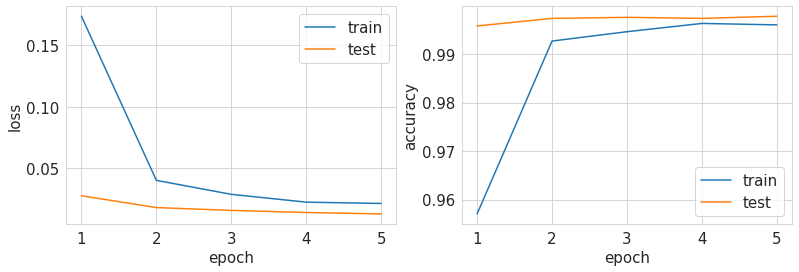

In [41]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

In [53]:
test_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

# val_dataset = Odin(root="/home/jupyter/datasphere/project/study-competition-2-dl-2024-1/data_cry/train1", train=False, 
#                      load_to_ram=True, transform=test_transform)
# test_dataset = Vtoroi(root="/home/jupyter/datasphere/project/study-competition-2-dl-2024-1/data_cry/test", train= False, load_to_ram=True, transform=test_transform)
# test_loader = DataLoader(
#     test_dataset, batch_size=params["batch_size"], shuffle=False, num_workers=params["num_workers"], pin_memory=True,
# )

In [70]:
folder_path = '/home/jupyter/datasphere/project/study-competition-2-dl-2024-1/data_cry/test'


preprocess = T.Compose([
    T.ToTensor()
])


results = pd.DataFrame(columns=['Image', 'Class'])


for filename in os.listdir(folder_path):
    if filename.endswith('.jpg'):
        
        img_path = os.path.join(folder_path, filename)
        img = Image.open(img_path).convert('RGB')
        image_number = int(os.path.splitext(filename)[0])
        
       
        img_tensor = preprocess(img)
        img_tensor = img_tensor.unsqueeze(0)  
        
      
        with torch.no_grad():
            logits = model(img_tensor)
        
        
        top_class = logits.argmax(dim=1).item()
        
       
        results = results.append({'Image': image_number, 'Class': top_class}, ignore_index=True)

In [71]:
print(results)

     Image Class
0        0     5
1        1    11
2       10     5
3      100    10
4     1000    13
...    ...   ...
2995   995    12
2996   996    14
2997   997     2
2998   998     8
2999   999     1

[3000 rows x 2 columns]


In [77]:
csv_path = '/home/jupyter/datasphere/project/study-competition-2-dl-2024-1/results.csv'

# Запись DataFrame в файл CSV
results.to_csv(csv_path, index=False)

# Проверка успешного сохранения файла
if os.path.exists(csv_path):
    print(f"Результаты были успешно сохранены в файле {csv_path}")
else:
    print("Ошибка при сохранении результатов в файл CSV")

Результаты были успешно сохранены в файле /home/jupyter/datasphere/project/study-competition-2-dl-2024-1/results.csv
